In [96]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-nashik-whether/sample_submission.csv
/kaggle/input/ml-olympiad-nashik-whether/train.csv
/kaggle/input/ml-olympiad-nashik-whether/test.csv


## 1. Data Loading and Initial Inspection

-   Import necessary libraries


In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

-   Load training and testing datasets

In [98]:
train_set=pd.read_csv("/kaggle/input/ml-olympiad-nashik-whether/train.csv")
test_set=pd.read_csv("/kaggle/input/ml-olympiad-nashik-whether/test.csv")

-   Display the first few rows of the training data


In [99]:
train_set

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,weather-condition
0,11,2022,1323,79.9,50.1,65.3,41.5,46.2,18.6,13.9,81.0,1014.2,4.9,9.3,230.0,19.9,clear-day
1,12,2022,1362,89.6,50.1,71.6,50.1,50.6,11.2,10.3,285.4,1018.2,4.3,7.1,214.8,18.7,clear-day
2,3,2022,1079,95.1,69.9,81.9,44.3,30.1,19.7,9.2,308.5,1009.9,61.7,6.5,240.5,20.8,partly-cloudy-day
3,5,2022,1148,93.3,72.6,81.7,66.2,61.8,27.1,20.8,264.7,1007.7,19.6,7.8,315.2,27.3,clear-day
4,11,2023,1694,85.4,67.4,73.5,62.9,71.2,18.8,15.2,158.2,1012.0,70.9,10.2,139.4,12.1,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,3,2022,1071,93.3,60.9,78.1,39.4,29.3,11.4,7.8,97.0,1012.4,0.0,9.9,275.0,23.9,clear-day
630,4,2022,1106,100.5,66.8,84.9,47.5,31.3,22.1,13.9,291.3,1008.5,3.8,7.1,313.2,26.9,clear-day
631,9,2022,1270,84.3,69.2,75.6,70.0,83.5,8.9,12.8,276.2,1009.4,61.9,6.4,187.6,16.3,rain
632,3,2023,1435,93.3,60.9,79.2,45.9,34.6,15.4,11.4,101.4,1013.0,21.1,6.5,279.2,24.1,partly-cloudy-day



-   Check for missing values in the training data

In [100]:
train_set.isnull().sum()

month                0
year                 0
ID                   0
tempmax              0
tempmin              0
temp                 0
dew                  0
humidity             0
windgust             7
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
solarradiation       0
solarenergy          0
weather-condition    0
dtype: int64

## 2. Data Preprocessing

**-   Handle missing values (imputation)**

In [101]:
categorical_columns=train_set.columns

for i in categorical_columns:
    train_set[i] = train_set[i].fillna(train_set[i].mode()[0])

In [102]:
train_set.isnull().sum()

month                0
year                 0
ID                   0
tempmax              0
tempmin              0
temp                 0
dew                  0
humidity             0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
solarradiation       0
solarenergy          0
weather-condition    0
dtype: int64

-   Check data types



In [103]:
train_set.dtypes

month                  int64
year                   int64
ID                     int64
tempmax              float64
tempmin              float64
temp                 float64
dew                  float64
humidity             float64
windgust             float64
windspeed            float64
winddir              float64
sealevelpressure     float64
cloudcover           float64
visibility           float64
solarradiation       float64
solarenergy          float64
weather-condition     object
dtype: object

In [104]:
train_set.columns

Index(['month', 'year', 'ID', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'weather-condition'],
      dtype='object')

**-   Identify and handle outliers**


In [105]:
def detect_outliers(train_set,n,features):
 
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(train_set[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(train_set[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = train_set[(train_set[col] < Q1 - outlier_step) | (train_set[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_set,2,['tempmax', 'tempmin', 'temp', 'dew', 'humidity',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy'])

In [106]:
train_set.loc[Outliers_to_drop]

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,weather-condition
115,8,2022,1223,78.9,70.8,74.4,71.6,91.4,37.6,21.0,228.9,1003.4,90.7,2.1,39.5,3.4,rain


In [107]:
    train_set = train_set.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

**-   Combine training and testing datasets**



In [108]:
train_len = len(train_set)
dataset =  pd.concat(objs=[train_set, test_set], axis=0).reset_index(drop=True)

**-   Re-check for missing values in the combined dataset**

In [109]:
dataset.isnull().sum()

month                  0
year                   0
ID                     0
tempmax                0
tempmin                0
temp                   0
dew                    0
humidity               0
windgust               2
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
weather-condition    159
dtype: int64

In [110]:
dataset = dataset.fillna(np.nan)

In [111]:
dataset.isnull().sum()

month                  0
year                   0
ID                     0
tempmax                0
tempmin                0
temp                   0
dew                    0
humidity               0
windgust               2
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
weather-condition    159
dtype: int64

In [112]:
missing_values = dataset["windgust"].isnull()


print(missing_values.index)


print(dataset[missing_values])

RangeIndex(start=0, stop=792, step=1)
     month  year    ID  tempmax  tempmin  temp   dew  humidity  windgust  \
774      1  2022  1007     77.1     57.3  66.9  61.1      83.6       NaN   
781      1  2022  1002     83.4     57.3  69.7  60.3      74.6       NaN   

     windspeed  winddir  sealevelpressure  cloudcover  visibility  \
774        9.4    277.9            1015.8        42.7         2.2   
781        8.3     94.4            1017.1        34.5         2.4   

     solarradiation  solarenergy weather-condition  
774           191.3         16.3               NaN  
781           191.7         16.5               NaN  


In [113]:
train_set.columns

Index(['month', 'year', 'ID', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'weather-condition'],
      dtype='object')

## 3. Feature Engineering and Encoding

**-   Encode categorical features using Label Encoding**

In [114]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_set['weather-condition'] = label_encoder.fit_transform(train_set['weather-condition'])

**-   Visualize correlations between features using a heatmap**

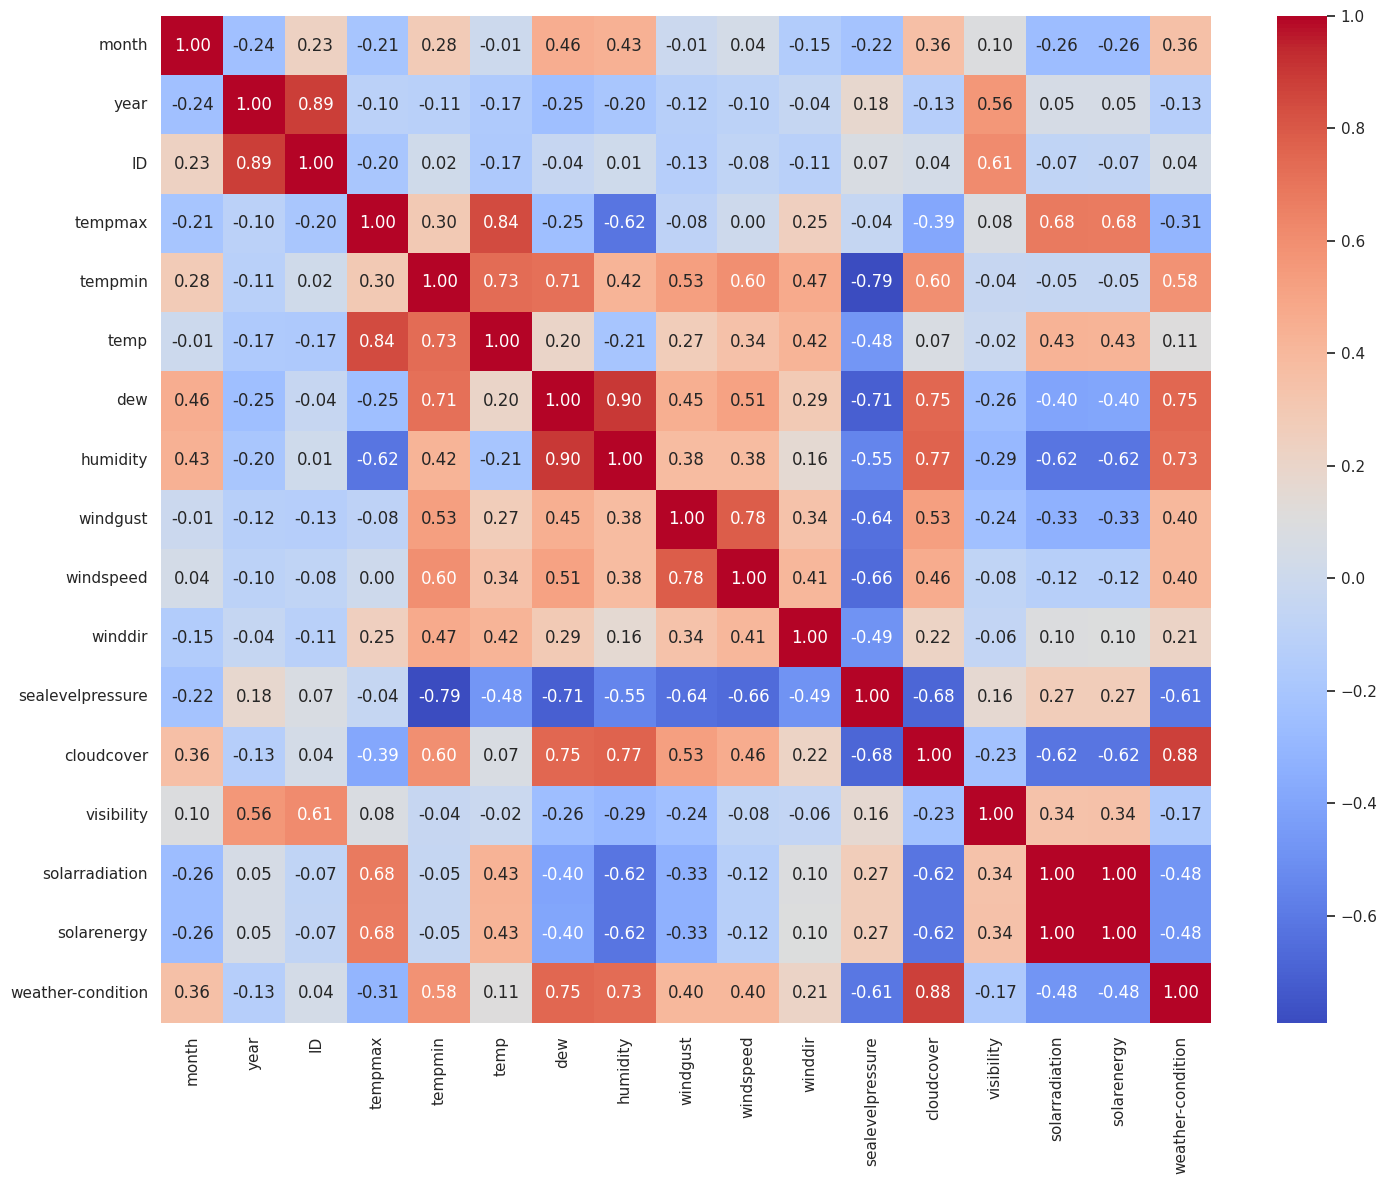

In [115]:
plt.figure(figsize=(15, 12))  # Adjust figure size

g = sns.heatmap(train_set[['month', 'year', 'ID', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity',
       'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'solarenergy', 'weather-condition']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
plt.tight_layout()

In [116]:
dataset["windgust"] = dataset["windgust"].fillna(dataset["windgust"].median())


In [117]:
print(dataset[missing_values])

     month  year    ID  tempmax  tempmin  temp   dew  humidity  windgust  \
774      1  2022  1007     77.1     57.3  66.9  61.1      83.6      18.1   
781      1  2022  1002     83.4     57.3  69.7  60.3      74.6      18.1   

     windspeed  winddir  sealevelpressure  cloudcover  visibility  \
774        9.4    277.9            1015.8        42.7         2.2   
781        8.3     94.4            1017.1        34.5         2.4   

     solarradiation  solarenergy weather-condition  
774           191.3         16.3               NaN  
781           191.7         16.5               NaN  


In [118]:
train_set.dtypes

month                  int64
year                   int64
ID                     int64
tempmax              float64
tempmin              float64
temp                 float64
dew                  float64
humidity             float64
windgust             float64
windspeed            float64
winddir              float64
sealevelpressure     float64
cloudcover           float64
visibility           float64
solarradiation       float64
solarenergy          float64
weather-condition      int64
dtype: object

In [119]:
for column in train_set.columns:
    unique_values = train_set[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

Unique values in column 'month': [11 12  3  5  8  2  7  4  1 10  9  6]
Unique values in column 'year': [2022 2023 2024]
Unique values in column 'ID': [1323 1362 1079 1148 1694 1213 1439 1411 1591 1133 1499 1209 1477 1055
 1420 1604 1682 1552 1367 1192 1291 1395 1060 1640 1723 1485 1631 1791
 1363 1644 1196 1588 1090 1412 1181 1716 1357 1264 1158 1069 1380 1131
 1044 1070 1494 1426 1593 1299 1135 1082 1165 1164 1028 1528 1193 1234
 1517 1567 1136 1409 1306 1140 1783 1006 1382 1731 1073 1641 1260 1145
 1336 1220 1749 1519 1132 1368 1625 1462 1742 1547 1041 1572 1108 1338
 1056 1425 1286 1551 1227 1212 1590 1326 1024 1139 1648 1344 1744 1394
 1051 1442 1726 1351 1493 1328 1281 1018 1581 1712 1083 1061 1424 1440
 1182 1773 1787 1417 1657 1314 1652 1436 1486 1176 1543 1356 1163 1248
 1515 1703 1074 1464 1398 1104 1114 1296 1092 1404 1089 1423 1506 1736
 1481 1487 1011 1346 1043 1042 1167 1696 1610 1405 1178 1527 1536 1177
 1571 1557 1257 1352 1465 1015 1511 1256 1396 1383 1332 1616 1622 136

In [120]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
columns_to_encode = train_set.columns[train_set.columns != 'ID']

train_set[columns_to_encode] = train_set[columns_to_encode].apply(lambda col: label_encoder.fit_transform(col))

In [121]:
train_set

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,weather-condition
0,10,0,1323,23,8,18,52,124,57,39,69,124,40,73,249,110,0
1,11,0,1362,79,8,72,120,156,24,23,407,158,36,52,181,99,0
2,2,0,1079,100,87,162,70,37,62,17,476,82,283,46,297,119,1
3,4,0,1148,94,102,160,234,233,95,70,321,61,133,59,501,181,0
4,10,1,1694,56,73,91,209,272,58,45,185,102,310,82,58,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,2,0,1071,94,42,137,36,33,25,11,128,106,0,79,417,149,0
629,3,0,1106,117,71,190,97,43,73,39,433,69,32,52,491,177,0
630,8,0,1270,47,83,112,267,326,14,34,370,77,285,45,104,75,2
631,2,1,1435,94,42,144,83,63,43,28,142,112,140,46,429,151,1


## 4. Data Scaling


**-   Apply MinMaxScaler to numerical features**

In [122]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = train_set.select_dtypes(include=['number']).columns.drop(['ID','month','year'])
scaler = MinMaxScaler()
train_set[numerical_columns] = scaler.fit_transform(train_set[numerical_columns])

In [123]:
train_set

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,weather-condition
0,10,0,1323,0.176923,0.064,0.079295,0.174497,0.299517,0.441860,0.475610,0.132438,0.751515,0.094563,0.744898,0.488235,0.597826,0.0
1,11,0,1362,0.607692,0.064,0.317181,0.402685,0.376812,0.186047,0.280488,0.781190,0.957576,0.085106,0.530612,0.354902,0.538043,0.0
2,2,0,1079,0.769231,0.696,0.713656,0.234899,0.089372,0.480620,0.207317,0.913628,0.496970,0.669031,0.469388,0.582353,0.646739,0.5
3,4,0,1148,0.723077,0.816,0.704846,0.785235,0.562802,0.736434,0.853659,0.616123,0.369697,0.314421,0.602041,0.982353,0.983696,0.0
4,10,1,1694,0.430769,0.584,0.400881,0.701342,0.657005,0.449612,0.548780,0.355086,0.618182,0.732861,0.836735,0.113725,0.239130,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,2,0,1071,0.723077,0.336,0.603524,0.120805,0.079710,0.193798,0.134146,0.245681,0.642424,0.000000,0.806122,0.817647,0.809783,0.0
629,3,0,1106,0.900000,0.568,0.837004,0.325503,0.103865,0.565891,0.475610,0.831094,0.418182,0.075650,0.530612,0.962745,0.961957,0.0
630,8,0,1270,0.361538,0.664,0.493392,0.895973,0.787440,0.108527,0.414634,0.710173,0.466667,0.673759,0.459184,0.203922,0.407609,1.0
631,2,1,1435,0.723077,0.336,0.634361,0.278523,0.152174,0.333333,0.341463,0.272553,0.678788,0.330969,0.469388,0.841176,0.820652,0.5


In [ ]:
for column in train_set.columns:
    unique_values = train_set[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")

## 5. Model Training and Evaluation

-   Binning the target variable ('weather-condition')
-   Splitting the training data into training and validation sets
-   Training a RandomForestClassifier
-   Evaluating the model using accuracy, F1-score, and classification report

In [131]:
num_bins = 3
train_set['weather-condition'] = pd.cut(train_set['weather-condition'], bins=num_bins, labels=False)


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score


X = train_set.drop(['weather-condition'] ,axis=1)
y = train_set['weather-condition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


random_forest = RandomForestClassifier(n_estimators=5, random_state=42)

random_forest.fit(X_train, y_train)


y_pred = random_forest.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score: {f1}")


print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9448818897637795
F1 Score: 0.9451388098178495
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        43
           1       0.85      0.97      0.90        29
           2       0.98      0.89      0.93        55

    accuracy                           0.94       127
   macro avg       0.94      0.95      0.94       127
weighted avg       0.95      0.94      0.95       127



## 6. Prediction on Test Data

**-  Preprocessing the test data (encoding, scaling)**

In [132]:
test_set

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy
0,5,2022,1137,100.5,71.5,85.3,61.1,50.5,17.4,13.9,276.5,1006.1,18.6,6.4,316.5,27.2
1,7,2022,1198,75.3,70.1,73.2,71.6,94.9,25.7,16.1,259.9,1006.3,98.3,4.1,23.7,2.0
2,1,2024,1739,86.1,65.6,74.1,58.0,59.6,15.0,9.4,78.2,1015.1,18.0,10.8,208.7,18.1
3,8,2023,1583,80.7,70.4,74.4,69.5,85.1,33.8,23.5,257.2,1005.5,88.1,11.4,204.2,17.7
4,10,2023,1655,87.2,71.0,77.9,62.5,60.7,15.4,10.5,25.1,1013.2,46.9,11.9,200.3,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,1,2024,1737,83.6,64.8,72.2,56.8,60.1,15.7,10.7,124.4,1014.5,42.1,9.7,136.0,11.6
155,2,2024,1760,80.7,56.6,68.3,49.5,53.3,17.4,8.3,293.7,1015.7,20.8,10.8,231.5,20.1
156,6,2023,1541,78.2,72.8,74.7,70.1,85.7,28.0,17.0,254.2,1004.3,96.8,9.9,72.5,6.1
157,1,2023,1375,86.1,44.7,67.8,38.8,39.9,10.3,10.3,319.1,1016.0,0.0,7.1,223.0,19.3


In [133]:
label_encoder = LabelEncoder()
columns_to_encode = test_set.columns[test_set.columns != 'ID']

test_set[columns_to_encode] = test_set[columns_to_encode].apply(lambda col: label_encoder.fit_transform(col))

In [134]:
test_set

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy
0,4,0,1137,53,56,90,81,49,37,30,107,17,46,17,148,90
1,6,0,1198,1,48,33,124,134,67,36,75,19,137,4,0,0
2,0,2,1739,22,35,40,74,77,28,16,18,83,44,48,23,23
3,7,1,1583,7,50,43,107,113,79,53,70,12,130,52,21,21
4,9,1,1655,26,53,66,84,79,30,20,1,66,83,54,17,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,2,1737,16,33,26,69,78,31,21,49,79,77,40,8,8
155,1,2,1760,7,12,8,39,57,37,11,125,87,47,48,73,42
156,5,1,1541,3,63,45,112,114,72,40,64,4,136,42,6,6
157,0,1,1375,22,1,5,6,29,11,19,140,89,0,23,56,34


In [135]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = test_set.select_dtypes(include=['number']).columns.drop(['ID','month','year'])
scaler = MinMaxScaler()
test_set[numerical_columns] = scaler.fit_transform(test_set[numerical_columns])

In [136]:
test_set

,month,year,ID,tempmax,tempmin,temp,dew,humidity,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy
0,4,0,1137,0.946429,0.708861,0.865385,0.623077,0.362963,0.451220,0.535714,0.703947,0.177083,0.328571,0.309091,1.000000,0.989011
1,6,0,1198,0.017857,0.607595,0.317308,0.953846,0.992593,0.817073,0.642857,0.493421,0.197917,0.978571,0.072727,0.000000,0.000000
2,0,2,1739,0.392857,0.443038,0.384615,0.569231,0.570370,0.341463,0.285714,0.118421,0.864583,0.314286,0.872727,0.155405,0.252747
3,7,1,1583,0.125000,0.632911,0.413462,0.823077,0.837037,0.963415,0.946429,0.460526,0.125000,0.928571,0.945455,0.141892,0.230769
4,9,1,1655,0.464286,0.670886,0.634615,0.646154,0.585185,0.365854,0.357143,0.006579,0.687500,0.592857,0.981818,0.114865,0.197802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,2,1737,0.285714,0.417722,0.250000,0.530769,0.577778,0.378049,0.375000,0.322368,0.822917,0.550000,0.727273,0.054054,0.087912
155,1,2,1760,0.125000,0.151899,0.076923,0.300000,0.422222,0.451220,0.196429,0.822368,0.906250,0.335714,0.872727,0.493243,0.461538
156,5,1,1541,0.053571,0.797468,0.432692,0.861538,0.844444,0.878049,0.714286,0.421053,0.041667,0.971429,0.763636,0.040541,0.065934
157,0,1,1375,0.392857,0.012658,0.048077,0.046154,0.214815,0.134146,0.339286,0.921053,0.927083,0.000000,0.418182,0.378378,0.373626


In [137]:
X_test=test_set
y_pred = random_forest.predict(X_test)

y_pred


array([2, 2, 0, 2, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1, 2, 0,
       1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 1, 2,
       2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 1, 2, 1, 0, 2, 1,
       1, 2, 0, 1, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 1,
       0, 2, 2, 0, 2, 2, 0, 2, 1, 0, 1, 0, 0, 0, 1, 2, 2, 1, 2, 0, 0, 1,
       1, 1, 2, 2, 0, 1, 2, 1, 1, 0, 2, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 0,
       1, 1, 0, 2, 0, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2, 2, 1,
       2, 1, 2, 0, 0])

-   Making predictions on the preprocessed test data
-   Inverse transforming the predicted labels

In [140]:
label_encoder = LabelEncoder()
original_labels = ["clear-day","partly-cloudy-day","rain" ]

label_encoder.fit(original_labels)

predicted_labels = label_encoder.inverse_transform(y_pred)


po=label_encoder.inverse_transform(y_pred)


output=pd.DataFrame({'ID': test_set['ID'],  
                     'weather-condition': po })


output.to_csv('submission1.csv',index=False)

## 7. Submission File 

In [139]:
output

,ID,weather-condition
0,1137,rain
1,1198,rain
2,1739,clear-day
3,1583,rain
4,1655,partly-cloudy-day
...,...,...
154,1737,rain
155,1760,partly-cloudy-day
156,1541,rain
157,1375,clear-day
